<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация чисел на основе базы MNIST

[Есть код](http://s6957389.stat-pulse.com/go/ec/a21e199f15c6b8797d6383824bc052e1/ci/OTA4ODc0Mw==/ui/Njk1NzM4OQ==/li/MjA4MDQzNTQx/re/aWZuZGVmQHlhbmRleC5ydQ==/l/aHR0cHMlM0ElMkYlMkZ3d3cuZHJvcGJveC5jb20lMkZzJTJGMmV5cmg3YmNqbXVuY2pjJTJGZ2VuZXJhdGl2ZTEuemlwJTNGZGwlM0Qw/) обычной генеративной сети. Сделать на основе него генерацию с условием на той же базе MNIST. Значит, для генерации мы подаем не только вектор шума, но и число от 0 до 9 (one-hot вектор) – на вход и генератору, и дискриминатору. 
 

## Подготовка окружения

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from IPython.display import Image

import sys
import datetime
import imageio

import numpy as np

### Входные данные

In [0]:
num_classes = 10
target_number = 8
target_vector = to_categorical(target_number, num_classes = num_classes)

epochs = 10000
sample_interval = 200
log_interval = 100
latent_dim = 10

### Папка для выходных данных

In [96]:
folder_name = "gen_%s" % target_number
print(folder_name)
!rm -fr {folder_name}
!mkdir {folder_name}

gen_8


 ## Создание и обучение генеративной нейросети

In [97]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100

    self.noise_shape = (self.latent_dim,)
    self.labels_shape = (num_classes,)

    optimizer = Adam(0.0002, 0.5)

#   Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # The generator takes noise as input and generates imgs
    noise_input = Input(self.noise_shape)
    label_input = Input(self.labels_shape)
    img = self.generator([noise_input, label_input])

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = self.discriminator([img, label_input])

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    self.combined = Model([noise_input, label_input], validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):
    print("\n----- Creating Generator -----\n")

    # Input
    noise_input = Input(self.noise_shape)
    label_input = Input(self.labels_shape)
    concat_layer= Concatenate()([noise_input, label_input])
    
    # Layers
    x = Dense(256, input_dim=self.latent_dim + 10)(concat_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Dense(np.prod(self.img_shape), activation='tanh')(x)
    x = Reshape(self.img_shape)(x)
    
    generator = Model(inputs = [noise_input, label_input], outputs = x, name='generator')
#     generator.summary()
    return generator
    
  def build_discriminator(self):
    print("\n----- Creating Discriminator -----\n")

    # Input
    image_input = Input(self.img_shape)
    label_input = Input(self.labels_shape)
    
    # Layers
    x = Flatten(input_shape=self.img_shape)(image_input)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Concatenate()([x, label_input])
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs = [image_input, label_input], outputs = x, name="discriminator")
#     discriminator.summary()
    return discriminator
  
  def train(self, target, epochs, batch_size=128, sample_interval=50):
    target_vector = to_categorical(target, num_classes=10)
    
    # Load the dataset
    (X_train, Y_train), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    fake_labels = np.stack([target_vector for _ in range(batch_size)])

    for epoch in range(epochs):

      # ---------------------
      #  Train Discriminator
      # ---------------------

      # Select a random batch of images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
      labels = to_categorical(Y_train[idx], num_classes=10)

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Generate a batch of new images
      gen_imgs = self.generator.predict([noise, fake_labels])

      # Train the discriminator
      d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
      d_loss_fake = self.discriminator.train_on_batch([gen_imgs, fake_labels], fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # ---------------------
      #  Train Generator
      # ---------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Train the generator (to have the discriminator label samples as valid)
      g_loss = self.combined.train_on_batch([noise, fake_labels], valid)

      # Plot the progress
      if epoch % log_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

      # If at save interval => save generated image samples
      if epoch % sample_interval == 0:
          self.sample_images(epoch, target_vector)

  def sample_images(self, epoch, target_vector):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    labels = np.stack([target_vector for _ in range(r * c)])
    
    gen_imgs = self.generator.predict([noise, labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig("%s/%d.png" % (folder_name, epoch))
    plt.close()
    
gan = GAN()
gan.train(epochs=epochs + 1, target=2, batch_size=32, sample_interval=sample_interval)



----- Creating Discriminator -----


----- Creating Generator -----



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.887384, acc.: 37.50%] [G loss: 0.672079]
100 [D loss: 0.007951, acc.: 100.00%] [G loss: 4.530915]
200 [D loss: 0.167689, acc.: 96.88%] [G loss: 3.214188]
300 [D loss: 0.244459, acc.: 95.31%] [G loss: 1.944726]
400 [D loss: 0.225228, acc.: 93.75%] [G loss: 2.008129]
500 [D loss: 0.245911, acc.: 92.19%] [G loss: 2.031672]
600 [D loss: 0.217570, acc.: 93.75%] [G loss: 2.264829]
700 [D loss: 0.291443, acc.: 90.62%] [G loss: 2.079942]
800 [D loss: 0.181726, acc.: 95.31%] [G loss: 2.376843]
900 [D loss: 0.217326, acc.: 93.75%] [G loss: 2.548512]
1000 [D loss: 0.131555, acc.: 96.88%] [G loss: 2.563831]
1100 [D loss: 0.162834, acc.: 95.31%] [G loss: 2.490284]
1200 [D loss: 0.222299, acc.: 93.75%] [G loss: 2.297794]
1300 [D loss: 0.157487, acc.: 95.31%] [G loss: 2.673288]
1400 [D loss: 0.379227, acc.: 87.50%] [G loss: 2.121438]
1500 [D loss: 0.120836, acc.: 96.88%] [G loss: 2.624972]
1600 [D loss: 0.152424, acc.: 95.31%] [G loss: 2.539981]
1700 [D loss: 0.130790, acc.: 96.88%] [G l

## Визуализация результата

### Генерация GIF

In [0]:
def folder_to_gif(folder, output_file):
  images = []
  for index in np.arange(0, epochs, sample_interval):
    images.append(imageio.imread("%s/%s.png" % (folder, index)))
  
  imageio.mimsave(output_file, images)

In [0]:
# print(np.arange(0, epochs, sample_interval))
output_file = 'training-%s-%s.gif' % (target_number, datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))
folder_to_gif(folder_name, output_file)

### Результат работы генератора

gen_8/10000.png


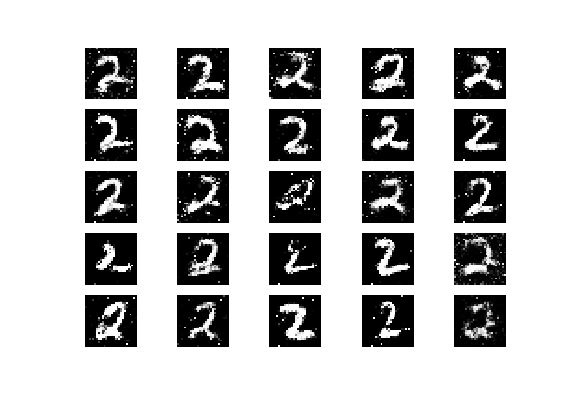

In [100]:
last_file = "%s/%s.png" % (folder_name, epochs)
print(last_file)

with open(last_file,'rb') as f:
    display(Image(data=f.read(), format='png'))